### Problem Statement

Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
airlines=pd.read_excel('Airlines+Data.xlsx')
airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


### Data Understanding

In [3]:
airlines.shape

(96, 2)

In [4]:
airlines.isna().sum()

Month         0
Passengers    0
dtype: int64

In [5]:
airlines.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [6]:
airlines[airlines.duplicated()]

,Month,Passengers


### Data Preparation - Part 1

In [7]:
airlines=airlines.rename(columns={'Month':'Date'})
airlines['year']=airlines['Date'].dt.strftime('%Y')
airlines['month']=airlines['Date'].dt.strftime('%b')
airlines.head()

,Date,Passengers,year,month
0,1995-01-01,112,1995,Jan
1,1995-02-01,118,1995,Feb
2,1995-03-01,132,1995,Mar
3,1995-04-01,129,1995,Apr
4,1995-05-01,121,1995,May


### Data Visualization

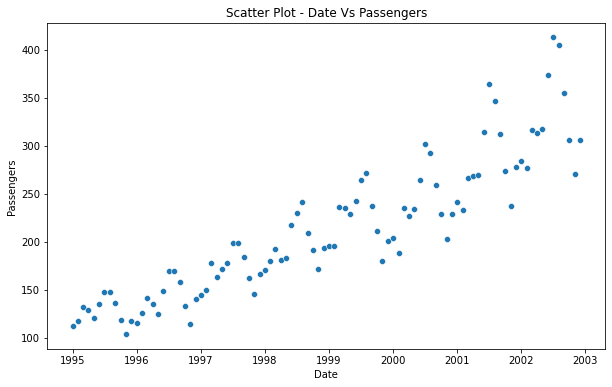

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(airlines.Date,airlines.Passengers)
plt.title('Scatter Plot - Date Vs Passengers')
plt.show()

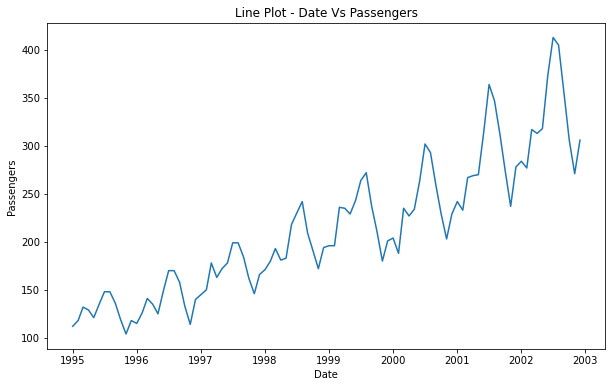

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(airlines.Date,airlines.Passengers)
plt.title('Line Plot - Date Vs Passengers')
plt.show()

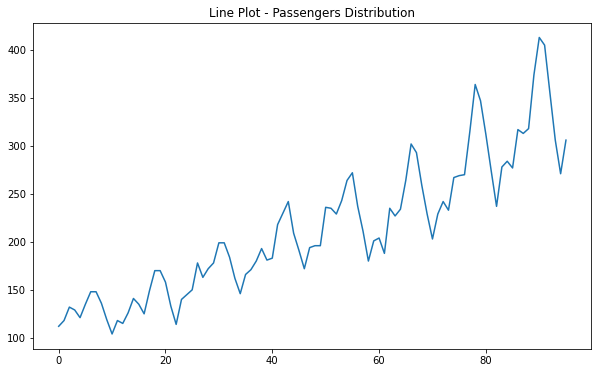

In [10]:
airlines.Passengers.plot(figsize=(10,6))
plt.title('Line Plot - Passengers Distribution')
plt.show()

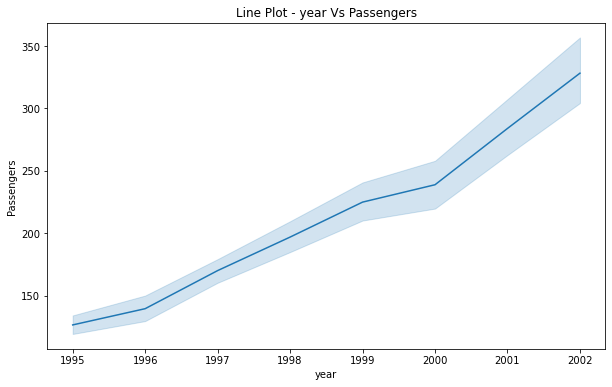

In [11]:
plt.figure(figsize=(10,6))
sns.lineplot(airlines.year,airlines.Passengers)
plt.title('Line Plot - year Vs Passengers')
plt.show()

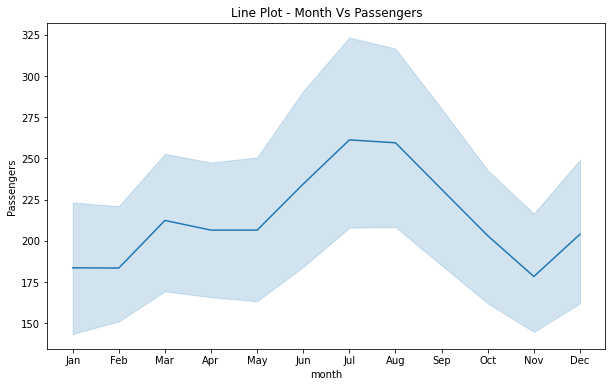

In [12]:
plt.figure(figsize=(10,6))
sns.lineplot(airlines.month,airlines.Passengers)
plt.title('Line Plot - Month Vs Passengers')
plt.show()

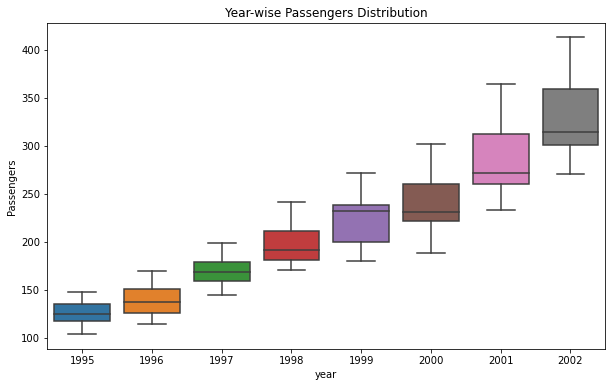

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(airlines.year,airlines.Passengers)
plt.title('Year-wise Passengers Distribution')
plt.show()

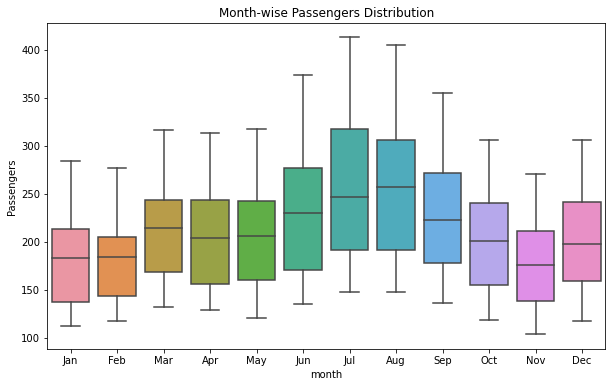

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(airlines.month,airlines.Passengers)
plt.title('Month-wise Passengers Distribution')
plt.show()

In [15]:
monthwise=pd.pivot_table(data=airlines,values='Passengers',index='month',columns='year')
monthwise

year,1995,1996,1997,1998,1999,2000,2001,2002
month,,,,,,,,
Apr,129,135,163,181,235,227,269,313
Aug,148,170,199,242,272,293,347,405
Dec,118,140,166,194,201,229,278,306
Feb,118,126,150,180,196,188,233,277
Jan,112,115,145,171,196,204,242,284
Jul,148,170,199,230,264,302,364,413
Jun,135,149,178,218,243,264,315,374
Mar,132,141,178,193,236,235,267,317
May,121,125,172,183,229,234,270,318


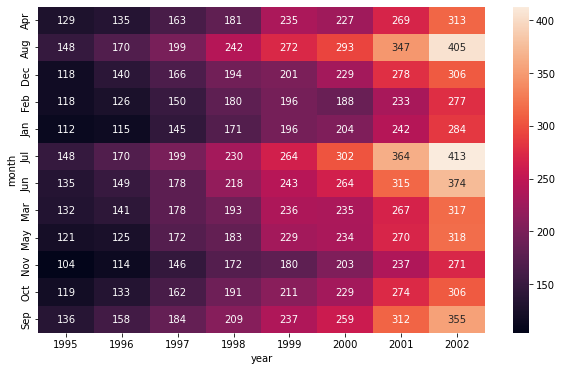

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(monthwise,annot=True,fmt='g')
plt.show()

### Data Preparation - Part 2.

In [17]:
t=np.arange(1,airlines.shape[0]+1)
t_square=t*t
log_passengers=np.log(airlines['Passengers'])
dummies=pd.get_dummies(airlines['month'])

In [18]:
airlines['t']=pd.Series(t)
airlines['t_square']=pd.Series(t_square)
airlines['log_passengers']=pd.Series(log_passengers)
airlines=airlines.join(dummies)

In [19]:
airlines.head()

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,1995,Jan,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,1995,Feb,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,1995,Mar,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,1995,Apr,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,1995,May,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


## 1. Model Driven Forecasting Technique

### Model Building

In [20]:
training_data=airlines.head(airlines.shape[0]-12)
testing_data=airlines.tail(12)
training_data.shape,testing_data.shape

((84, 19), (12, 19))

### Model Training || Model Prediction || Model Evaluation

#### Linear Model

In [21]:
linear_model = smf.ols(formula='Passengers~t',data=training_data).fit()

pred_linear=linear_model.predict(testing_data)

linear_rmse=np.round(mean_squared_error(testing_data['Passengers'],pred_linear,squared=False),3)
linear_rmse

53.199

#### Exponential Model

In [22]:
exponential_model = smf.ols(formula='log_passengers~t',data=training_data).fit()

pred_exponential=exponential_model.predict(testing_data)

exponential_rmse=np.round(mean_squared_error(testing_data['Passengers'],np.exp(pred_exponential),squared=False),3)
exponential_rmse

46.057

#### Quadratic Model

In [23]:
quadratic_model = smf.ols(formula='Passengers~t+t_square',data=training_data).fit()

pred_quadratic=quadratic_model.predict(testing_data)

quadratic_rmse=np.round(mean_squared_error(testing_data['Passengers'],pred_quadratic,squared=False),3)
quadratic_rmse

48.052

#### Additive Seasonality Model

In [24]:
additive_model = smf.ols(formula='Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_additive=additive_model.predict(testing_data)

additive_rmse=np.round(mean_squared_error(testing_data['Passengers'],pred_additive,squared=False),3)
additive_rmse

132.82

#### Additive Seasonality with Quadratic Trend Model

In [25]:
additive_quad_model = smf.ols(formula='Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_additive_quad=additive_quad_model.predict(testing_data)

additive_quad_rmse=np.round(mean_squared_error(testing_data['Passengers'],pred_additive_quad,squared=False),3)
additive_quad_rmse

26.361

#### Multiplicative Model

In [26]:
multiplicative_model = smf.ols(formula='log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=training_data).fit()

pred_multiplicative=multiplicative_model.predict(testing_data)

multiplicative_rmse=np.round(mean_squared_error(testing_data['Passengers'],np.exp(pred_multiplicative),squared=False),3)
multiplicative_rmse

140.063

### Compare the Results

In [27]:
Model_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Linear','Exponential','Quadrative','Additive','Additive with Quadrative','Multiplicative']),
          "RMSE":pd.Series([linear_rmse,exponential_rmse,quadratic_rmse,additive_rmse,additive_quad_rmse,multiplicative_rmse])})
Model_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
4,Additive with Quadrative,26.361
1,Exponential,46.057
2,Quadrative,48.052
0,Linear,53.199
3,Additive,132.820
5,Multiplicative,140.063


#### From Model Driven Techniques, Additive with Quadrative Model gives least Root Mean Squared Error

### Build model for Complete Dataset

In [28]:
airlines_test=pd.read_excel('airlines_test.xlsx')
airlines_test

,Date,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2003-01-01,97,9409,1,0,0,0,0,0,0,0,0,0,0,0
1,2003-02-01,98,9604,0,1,0,0,0,0,0,0,0,0,0,0
2,2003-03-01,99,9801,0,0,1,0,0,0,0,0,0,0,0,0
3,2003-04-01,100,10000,0,0,0,1,0,0,0,0,0,0,0,0
4,2003-05-01,101,10201,0,0,0,0,1,0,0,0,0,0,0,0
5,2003-06-01,102,10404,0,0,0,0,0,1,0,0,0,0,0,0
6,2003-07-01,103,10609,0,0,0,0,0,0,1,0,0,0,0,0
7,2003-08-01,104,10816,0,0,0,0,0,0,0,1,0,0,0,0
8,2003-09-01,105,11025,0,0,0,0,0,0,0,0,1,0,0,0
9,2003-10-01,106,11236,0,0,0,0,0,0,0,0,0,1,0,0


In [29]:
airlines_test.dtypes

Date        datetime64[ns]
t                    int64
t_square             int64
Jan                  int64
Feb                  int64
Mar                  int64
Apr                  int64
May                  int64
Jun                  int64
Jul                  int64
Aug                  int64
Sep                  int64
Oct                  int64
Nov                  int64
Dec                  int64
dtype: object

In [30]:
additive_quad_final_model = smf.ols(formula='Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=airlines).fit()

pred_additive_quad_final=additive_quad_final_model.predict(airlines_test)

additive_quad_final_rmse=np.round(mean_squared_error(testing_data['Passengers'],pred_additive_quad_final,squared=False),3)
print(f"Final RMSE is : {additive_quad_final_rmse}")

Final RMSE is : 41.831


In [31]:
airlines_test['Predicted']=pred_additive_quad_final.astype('int')
airlines_test

,Date,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Predicted
0,2003-01-01,97,9409,1,0,0,0,0,0,0,0,0,0,0,0,328
1,2003-02-01,98,9604,0,1,0,0,0,0,0,0,0,0,0,0,329
2,2003-03-01,99,9801,0,0,1,0,0,0,0,0,0,0,0,0,359
3,2003-04-01,100,10000,0,0,0,1,0,0,0,0,0,0,0,0,354
4,2003-05-01,101,10201,0,0,0,0,1,0,0,0,0,0,0,0,356
5,2003-06-01,102,10404,0,0,0,0,0,1,0,0,0,0,0,0,385
6,2003-07-01,103,10609,0,0,0,0,0,0,1,0,0,0,0,0,413
7,2003-08-01,104,10816,0,0,0,0,0,0,0,1,0,0,0,0,412
8,2003-09-01,105,11025,0,0,0,0,0,0,0,0,1,0,0,0,385
9,2003-10-01,106,11236,0,0,0,0,0,0,0,0,0,1,0,0,358


In [32]:
full_data=pd.concat([airlines,airlines_test])
full_data.tail(12)

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Predicted
0,2003-01-01,NaN,NaN,NaN,97,9409,NaN,0,0,0,0,1,0,0,0,0,0,0,0,328.0
1,2003-02-01,NaN,NaN,NaN,98,9604,NaN,0,0,0,1,0,0,0,0,0,0,0,0,329.0
2,2003-03-01,NaN,NaN,NaN,99,9801,NaN,0,0,0,0,0,0,0,1,0,0,0,0,359.0
3,2003-04-01,NaN,NaN,NaN,100,10000,NaN,1,0,0,0,0,0,0,0,0,0,0,0,354.0
4,2003-05-01,NaN,NaN,NaN,101,10201,NaN,0,0,0,0,0,0,0,0,1,0,0,0,356.0
5,2003-06-01,NaN,NaN,NaN,102,10404,NaN,0,0,0,0,0,0,1,0,0,0,0,0,385.0
6,2003-07-01,NaN,NaN,NaN,103,10609,NaN,0,0,0,0,0,1,0,0,0,0,0,0,413.0
7,2003-08-01,NaN,NaN,NaN,104,10816,NaN,0,1,0,0,0,0,0,0,0,0,0,0,412.0
8,2003-09-01,NaN,NaN,NaN,105,11025,NaN,0,0,0,0,0,0,0,0,0,0,0,1,385.0
9,2003-10-01,NaN,NaN,NaN,106,11236,NaN,0,0,0,0,0,0,0,0,0,0,1,0,358.0


### Visualization

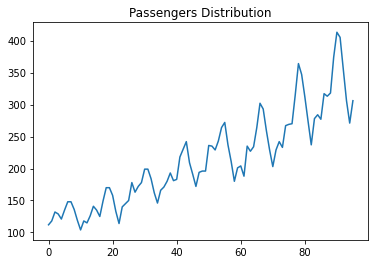

In [33]:
airlines['Passengers'].plot()
plt.title('Passengers Distribution')
plt.show()

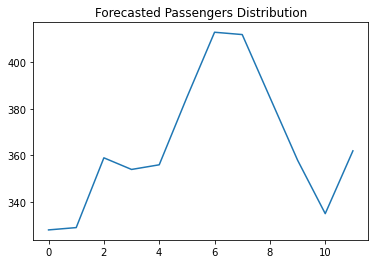

In [34]:
airlines_test['Predicted'].plot()
plt.title('Forecasted Passengers Distribution')
plt.show()

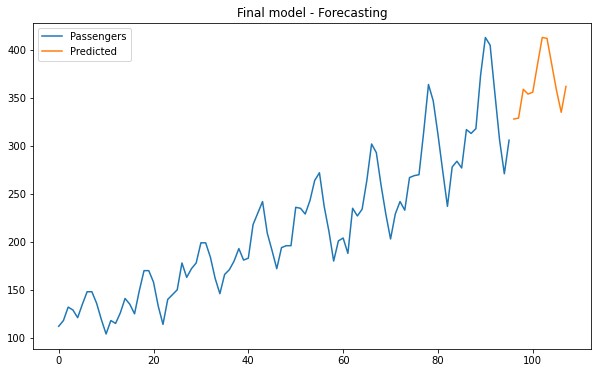

In [35]:
full_data[['Passengers','Predicted']].reset_index(drop=True).plot(figsize=(10,6))
plt.title('Final model - Forecasting',)
plt.show()

## 2. Data Driven Forecasting Techniques

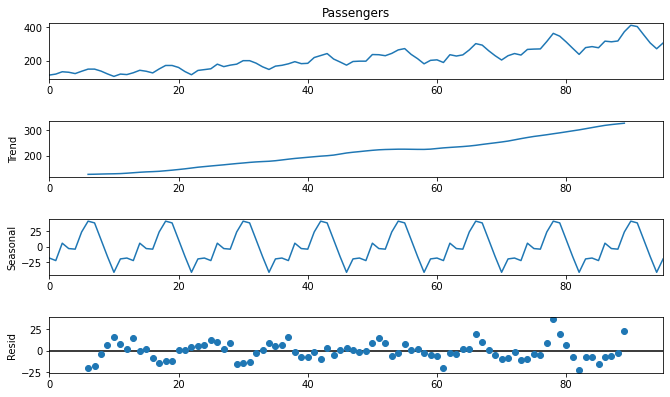

In [36]:
seasonal_de_compose=seasonal_decompose(airlines['Passengers'],period=12)
fig=seasonal_de_compose.plot()
fig.set_size_inches(10,6)
plt.show()

### Set 1 :

### Simple Average Model

In [37]:
airlines['Simple_Average']=pd.Series()
for i in range (0,airlines.shape[0]):
    avg=np.round(np.mean(airlines['Passengers'][:i]))
    airlines['Simple_Average'].at[i]=avg
airlines.head()

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average
0,1995-01-01,112,1995,Jan,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0,NaN
1,1995-02-01,118,1995,Feb,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0,112.0
2,1995-03-01,132,1995,Mar,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0,115.0
3,1995-04-01,129,1995,Apr,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0,121.0
4,1995-05-01,121,1995,May,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0,123.0


In [38]:
airlines=airlines.fillna(0)
airlines.head()

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average
0,1995-01-01,112,1995,Jan,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1,1995-02-01,118,1995,Feb,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0,112.0
2,1995-03-01,132,1995,Mar,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0,115.0
3,1995-04-01,129,1995,Apr,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0,121.0
4,1995-05-01,121,1995,May,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0,123.0


In [39]:
rmse_avg=np.round(mean_squared_error(airlines.Passengers,airlines.Simple_Average,squared=False),3)
rmse_avg

73.044

### Moving Average Model

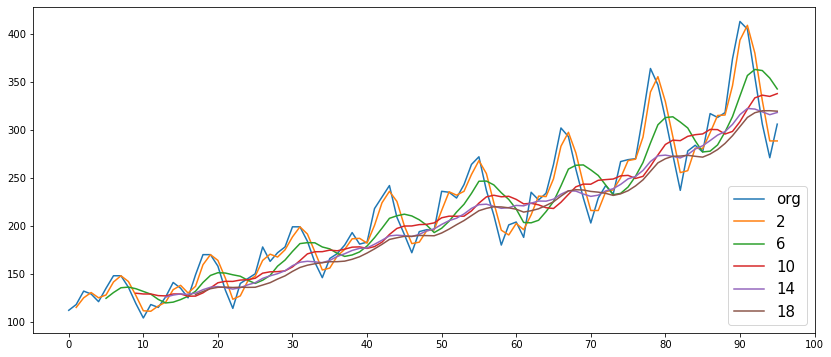

In [40]:
#Plotting Moving average model

plt.figure(figsize=(14,6))
airlines['Passengers'].plot(label='org')
for i in range(2,19,4):
    airlines['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='lower right',fontsize =15)
plt.xticks(np.arange(0,110,10))
plt.show()

In [41]:
airlines['Moving_Average']=airlines['Passengers'].rolling(3).mean().round()

In [42]:
airlines=airlines.fillna(0)
airlines.head()

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average,Moving_Average
0,1995-01-01,112,1995,Jan,1,1,4.718499,0,0,0,...,1,0,0,0,0,0,0,0,0.0,0.0
1,1995-02-01,118,1995,Feb,2,4,4.770685,0,0,0,...,0,0,0,0,0,0,0,0,112.0,0.0
2,1995-03-01,132,1995,Mar,3,9,4.882802,0,0,0,...,0,0,0,1,0,0,0,0,115.0,121.0
3,1995-04-01,129,1995,Apr,4,16,4.859812,1,0,0,...,0,0,0,0,0,0,0,0,121.0,126.0
4,1995-05-01,121,1995,May,5,25,4.795791,0,0,0,...,0,0,0,0,1,0,0,0,123.0,127.0


In [43]:
rmse_moving_avg=np.round(mean_squared_error(airlines.Passengers,airlines.Moving_Average,squared=False),3)
rmse_moving_avg

25.187

### Weighted Moving Average Model

In [44]:
weights=[0.5,0.3,0.2]
sum_weights=np.sum(weights)

In [45]:
airlines['Weighted_Moving_Average']=airlines['Passengers'].rolling(3).apply(lambda x : np.sum(x*weights)/sum_weights,).round()

In [46]:
airlines=airlines.fillna(0)
airlines.head()

,Date,Passengers,year,month,t,t_square,log_passengers,Apr,Aug,Dec,...,Jul,Jun,Mar,May,Nov,Oct,Sep,Simple_Average,Moving_Average,Weighted_Moving_Average
0,1995-01-01,112,1995,Jan,1,1,4.718499,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,1995-02-01,118,1995,Feb,2,4,4.770685,0,0,0,...,0,0,0,0,0,0,0,112.0,0.0,0.0
2,1995-03-01,132,1995,Mar,3,9,4.882802,0,0,0,...,0,0,1,0,0,0,0,115.0,121.0,118.0
3,1995-04-01,129,1995,Apr,4,16,4.859812,1,0,0,...,0,0,0,0,0,0,0,121.0,126.0,124.0
4,1995-05-01,121,1995,May,5,25,4.795791,0,0,0,...,0,0,0,1,0,0,0,123.0,127.0,129.0


In [47]:
rmse_weighted_moving_avg=np.round(mean_squared_error(airlines.Passengers,airlines.Weighted_Moving_Average,squared=False),3)
rmse_weighted_moving_avg

29.349

#### Simple Average, Moving average, Weighted Moving average calculation done for finding least RMSE, which is Weighted Moving Average amonth these three.

### Set - 2

### Simple Exponential Smoothing Technique

In [48]:
ses=SimpleExpSmoothing(endog=training_data['Passengers']).fit(smoothing_level=0.2)

pred_ses = ses.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_ses=np.round(mean_squared_error(testing_data['Passengers'],pred_ses,squared=False),3)
rmse_ses

64.845

### Holts Technique

In [49]:
holt=Holt(endog=training_data['Passengers']).fit(smoothing_level=0.8,smoothing_slope=0.2)

pred_holt = holt.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_holt=np.round(mean_squared_error(testing_data['Passengers'],pred_holt,squared=False),3)
rmse_holt

95.767

### Winter's Exponential Technique - Additive Seasonality and Additive Trend

In [50]:
winter_add_add=ExponentialSmoothing(endog=training_data['Passengers'],seasonal='add',trend='add',seasonal_periods=12).fit()

pred_winter_add_add = winter_add_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_add_add=np.round(mean_squared_error(testing_data['Passengers'],pred_winter_add_add,squared=False),3)
rmse_winter_add_add

28.794

### Winter's Exponential Technique - Multiplicative Seasonality and Additive Trend

In [51]:
winter_mul_add=ExponentialSmoothing(endog=training_data['Passengers'],seasonal='mul',trend='add',seasonal_periods=12).fit()

pred_winter_mul_add = winter_mul_add.predict(start =testing_data.index[0],end=testing_data.index[-1])

rmse_winter_mul_add=np.round(mean_squared_error(testing_data['Passengers'],pred_winter_mul_add,squared=False),3)
rmse_winter_mul_add

12.921

### Compare the Results

In [52]:
pd.set_option('display.max_colwidth',None)
Data_Driven_Results = pd.DataFrame(
    data={"MODEL":pd.Series(['Simple Exponential Smoothing','Holts','Winters Exponential Technique - Additive Seasonality and Additive Trend','Winters Exponential Technique - Multiplicative Seasonality and Additive Trend']),
          "RMSE":pd.Series([rmse_ses,rmse_holt,rmse_winter_add_add,rmse_winter_mul_add])})
Data_Driven_Results.sort_values('RMSE')

,MODEL,RMSE
3,Winters Exponential Technique - Multiplicative Seasonality and Additive Trend,12.921
2,Winters Exponential Technique - Additive Seasonality and Additive Trend,28.794
0,Simple Exponential Smoothing,64.845
1,Holts,95.767


#### From Data Driven Models, We can see that Winters Exponential Technique with Multiplicative Seasonality and Additive Treend has least RMSE

### Build model for Complete Dataset

In [53]:
winter_mul_add_final=ExponentialSmoothing(endog=airlines['Passengers'],seasonal='mul',trend='add',seasonal_periods=12).fit()

winter_mul_add_final.forecast(12)

96     312.899164
97     308.170903
98     355.533272
99     345.770384
100    345.697110
101    392.472018
102    436.501550
103    429.860620
104    380.172862
105    332.318642
106    290.626602
107    330.591802
dtype: float64

## 3. ARIMA

### Evaluate Arima Model

In [54]:
def evaluate_arima_model(X,arima_order):
    train_size=int(len(X)*0.5)
    train,test = X[0:train_size],X[train_size:]
    history = [i for i in train]
    predictions = list()
    for t in range(0,len(test)):
        model = ARIMA(endog =history,order = arima_order).fit(disp=0)
        yhat  = model.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    RMSE = mean_squared_error(test, predictions,squared=False)
    return RMSE

### Grid Search for ARIMA Order

In [55]:
def evaluate_order(dataset, p_values, q_values, d_values):
    dataset = dataset.astype('float32')
    best_score,best_order = float('inf'),None
    for p in p_values:
        for q in q_values:
            for d in d_values:
                try:
                    order = (p,q,d)
                    rmse = evaluate_arima_model(dataset,order)
                    print(f"RMSE is {rmse} and Order is {order}")
                    if rmse < best_score:
                        best_score,best_order = rmse,order
                except:
                    continue
    print(f"Best Score is {best_score} and Best Order is {best_order}")         

In [56]:
data = airlines.iloc[:,1]
data = data.values
train_size=int(len(data)-12)
train_data,test_data = data[0:train_size],data[train_size:]
train_data.shape,test_data.shape

((84,), (12,))

In [57]:
p_values = range(0,4)
q_values = range(0,4)
d_values = range(0,4)
warnings.filterwarnings('ignore')
evaluate_order(train_data,p_values, q_values, d_values)

RMSE is 78.35585260207598 and Order is (0, 0, 0)
RMSE is 44.790186076993365 and Order is (0, 0, 1)
RMSE is 26.205641378513043 and Order is (0, 1, 0)
RMSE is 25.581877848839333 and Order is (0, 1, 1)
RMSE is 28.099255197795262 and Order is (0, 1, 2)
RMSE is 23.953429935355206 and Order is (0, 1, 3)
RMSE is 32.5449751144607 and Order is (0, 2, 0)
RMSE is 26.938943869631785 and Order is (0, 2, 1)
RMSE is 26.17541969249041 and Order is (0, 2, 2)
RMSE is 28.23005108404201 and Order is (0, 2, 3)
RMSE is 26.445369417410674 and Order is (1, 0, 0)
RMSE is 25.610665651971935 and Order is (1, 0, 1)
RMSE is 25.93973565024607 and Order is (1, 1, 0)
RMSE is 31.784120911819585 and Order is (1, 2, 0)
RMSE is 25.99148941306792 and Order is (2, 0, 0)
RMSE is 25.658932988759286 and Order is (2, 1, 0)
RMSE is 30.765975425212517 and Order is (2, 2, 0)
RMSE is 25.820348607582726 and Order is (3, 0, 0)
RMSE is 25.25034472960106 and Order is (3, 0, 1)
RMSE is 25.764624928038355 and Order is (3, 1, 0)
RMSE is 

### Build Model based on Optimum Arima Order

In [58]:
model_final = ARIMA(train_data,(0, 1, 3)).fit()

In [59]:
forecast=model_final.forecast(12)[0]
forecast

array([304.4160511 , 299.86623757, 293.59368153, 295.75277859,
       297.91187566, 300.07097273, 302.23006979, 304.38916686,
       306.54826392, 308.70736099, 310.86645805, 313.02555512])

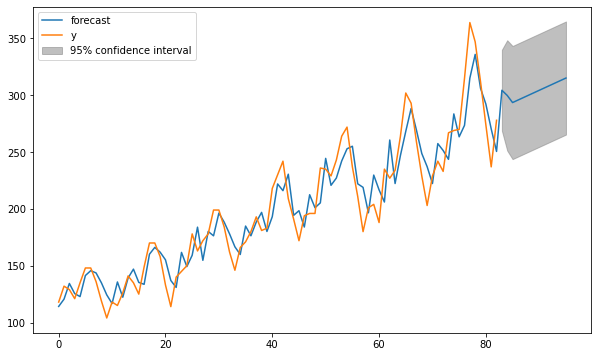

In [60]:
fig=model_final.plot_predict(1,96)
fig.set_size_inches(10,6)
plt.show()

In [61]:
RMSE_Optimum = np.round(mean_squared_error(test_data,forecast,squared=False))
RMSE_Optimum

53.0

#### RMSE by ARIMA Model is 53

### Evaluate for complete dataset

In [62]:
model_final_full_dataset = ARIMA(data,(0, 1, 3)).fit()

In [63]:
forecast=model_final_full_dataset.forecast(12)[0]
forecast

array([337.36162058, 335.40396648, 332.12913336, 334.46833451,
       336.80753565, 339.1467368 , 341.48593794, 343.82513908,
       346.16434023, 348.50354137, 350.84274252, 353.18194366])

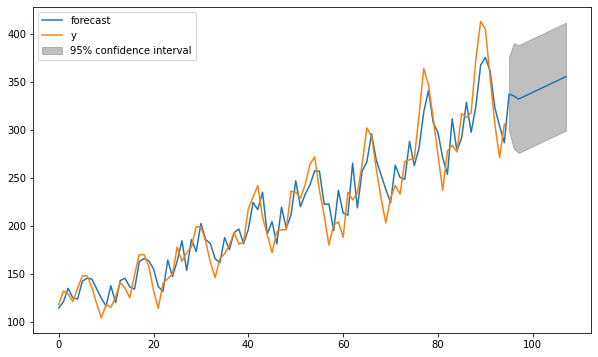

In [64]:
fig=model_final_full_dataset.plot_predict(1,108)
fig.set_size_inches(10,6)
plt.show()

### End !!!